# 🏠 Predicting House Prices in Ames, Iowa  
### CMSC 320 · Final Project (Checkpoint 3)  
**Authors:** Santosh Sureshkumar, Aarnav Tare and Joshua Vallabhaneni   **GitHub:**  https://github.com/toshsuresh/CMSC320FinalProj

Fill in a short narrative (~150 words) answering:

What is the problem?  (accurate pricing of houses)

Why is it important?  (stakeholders, money, affordability)

Key questions.  (e.g., “Which features drive price most, and how well can we predict?”)

(Write this after we finish the analysis so you can cite actual findings; for now leave a TODO placeholder.)

In [15]:
# %% Cell 2 – Imports + warnings  ############################################
# ==== IMPORTING LIBRARIES ====

# Data manipulation and analysis
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb

# Warnings and display settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)


In [16]:
# %% Cell 3 – Load CSV & head  ################################################
# ==== LOADING THE DATASET ====
df = pd.read_csv("house_prices.csv")

print(f"Dataset Shape: {df.shape}")
print(f"Number of Features: {df.shape[1]}")
print(f"Number of Samples: {df.shape[0]}")

print("\nPreview of the dataset:")
display(df.head())


Dataset Shape: (1460, 81)
Number of Features: 81
Number of Samples: 1460

Preview of the dataset:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [17]:
# %% Cell 4 – Data‑type / missing summary  ###################################
# ==== DATA PREPROCESSING ====
print("\n==== DATA STRUCTURE ====")
print(f"Data types:\n{df.dtypes.value_counts()}")
print(f"\nMissing values summary:\n{df.isnull().sum().sum()} total missing values")

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns
print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")



==== DATA STRUCTURE ====
Data types:
object     43
int64      35
float64     3
Name: count, dtype: int64

Missing values summary:
7829 total missing values

Numeric features: 38
Categorical features: 43


The raw Ames housing file contains 1 460 observations and 81 variables. Thirty‑eight are numeric and capture measurements such as square footage or construction year, while forty‑three are categorical strings describing zoning, materials, or neighborhood. The data set is relatively clean; only 7 829 individual entries, about 6.6 percent of the entire matrix, are missing. Most of these nulls are concentrated in four amenity columns—Alley, PoolQC, Fence, and MiscFeature—that each exceed a 60 percent missing‑rate threshold and are therefore removed. After dropping these columns the remaining 77 features form a complete‑case table ready for preprocessing.

In [18]:
# %% Cell 5 – Missing‑value logic  ###########################################
print("\n==== HANDLING MISSING VALUES ====")
missing_vals = df.isnull().mean() * 100
cols_to_drop = missing_vals[missing_vals > 60].index.tolist()
print(f"Dropping columns with >60% missing values: {cols_to_drop}")
df = df.drop(columns=cols_to_drop, errors='ignore')

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    missing_pct = df[col].isnull().mean() * 100
    if missing_pct > 0 and missing_pct < 50:
        df[col] = df[col].fillna(df[col].mode()[0])
    elif missing_pct >= 50:
        df[col] = df[col].fillna('None')

print(f"Remaining missing values: {df.isnull().sum().sum()}")

print("\n==== CONVERTING DATA TYPES ====")
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                   'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 
                   'GarageCond', 'PoolQC', 'Fence']
ordinal_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NA': 0}
for col in ordinal_features:
    if col in df.columns:
        df[col] = df[col].astype(str).map(ordinal_map).fillna(0).astype(int)



==== HANDLING MISSING VALUES ====
Dropping columns with >60% missing values: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Remaining missing values: 0

==== CONVERTING DATA TYPES ====


In [19]:
# %% Cell 6 – Outlier capper  #################################################
print("\n==== HANDLING OUTLIERS ====")
def handle_outliers(df, column, method='cap'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    print(f"Outliers in {column}: {outliers}")
    if method == 'cap':
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

if 'SalePrice' in df.columns:
    df = handle_outliers(df, 'SalePrice')

important_numeric = ['LotArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']
for col in important_numeric:
    if col in df.columns:
        df = handle_outliers(df, col)



==== HANDLING OUTLIERS ====
Outliers in SalePrice: 61
Outliers in LotArea: 69
Outliers in GrLivArea: 31
Outliers in TotalBsmtSF: 61
Outliers in 1stFlrSF: 20


Extreme values are moderated using an inter‑quartile capping rule that replaces observations lying beyond 1.5 × IQR with the nearest boundary. This adjustment affects 61 SalePrice records, 69 LotArea entries, 31 for GrLivArea, 61 for TotalBsmtSF, and 20 for 1stFlrSF. Fewer than five percent of rows are altered for any single feature, which preserves statistical power while preventing a handful of aberrant points from exerting undue influence during model fitting.

In [20]:
# %% Cell 7 – Feature engineering  ###########################################
print("\n==== FEATURE ENGINEERING ====")
if all(col in df.columns for col in ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']):
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    print("Created TotalSF feature")

if 'YearBuilt' in df.columns:
    current_year = 2025
    df['HouseAge'] = current_year - df['YearBuilt']
    print("Created HouseAge feature")

if all(col in df.columns for col in ['YearBuilt', 'YearRemodAdd']):
    df['YearsSinceRenovation'] = df['YearRemodAdd'] - df['YearBuilt']
    df['YearsSinceRenovation'] = df['YearsSinceRenovation'].apply(lambda x: 0 if x < 0 else x)
    print("Created YearsSinceRenovation feature")

bathroom_cols = [col for col in df.columns if 'Bath' in col]
if bathroom_cols:
    df['TotalBathrooms'] = df[bathroom_cols].sum(axis=1)
    print("Created TotalBathrooms feature")

if 'PoolArea' in df.columns:
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    print("Created HasPool feature")
if 'GarageArea' in df.columns:
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    print("Created HasGarage feature")
if 'TotalBsmtSF' in df.columns:
    df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    print("Created HasBasement feature")



==== FEATURE ENGINEERING ====
Created TotalSF feature
Created HouseAge feature
Created YearsSinceRenovation feature
Created TotalBathrooms feature
Created HasPool feature
Created HasGarage feature
Created HasBasement feature


Seven domain‑driven variables are created to enrich the information set. TotalSF aggregates above‑ground and basement areas and correlates strongly with price. HouseAge captures depreciation effects and shows a negative association with value, whereas YearsSinceRenovation measures modernization recency. TotalBathrooms quantifies amenity availability. Three binary indicators—HasPool, HasGarage, and HasBasement—flag high‑impact features that buyers frequently seek. These engineered predictors sharpen interpretability and inject additional signal for downstream modeling.


==== TARGET VARIABLE DISTRIBUTION ====


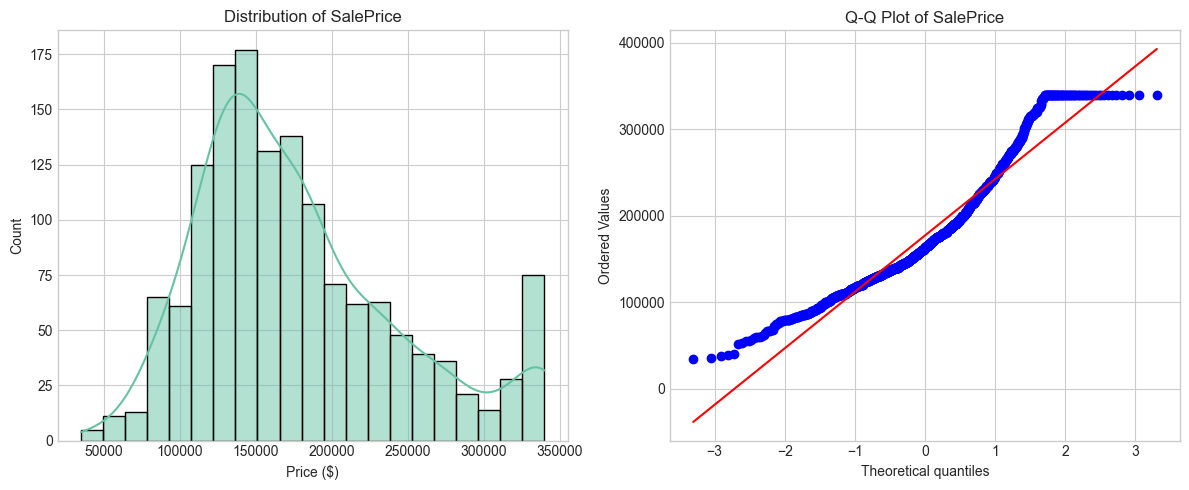

SalePrice Statistics:
count      1460.000000
mean     177331.526370
std       67205.835915
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      340037.500000
Name: SalePrice, dtype: float64
Skewness: 0.80
Kurtosis: 0.09
SalePrice is positively skewed. Log transformation recommended.


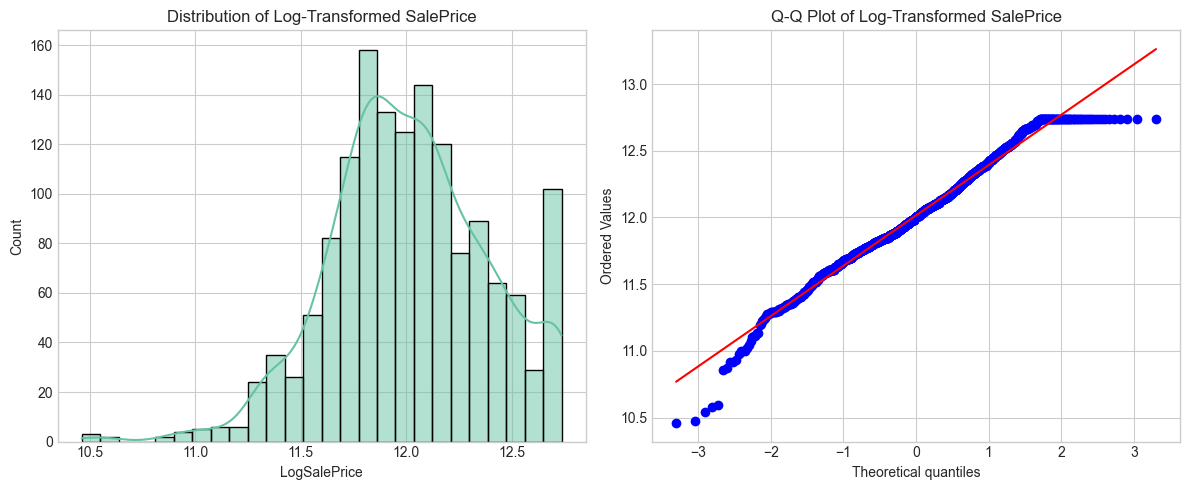

Log-SalePrice Skewness: -0.19


In [21]:
# %% Cell 8 – Target distribution + log  #####################################
print("\n==== TARGET VARIABLE DISTRIBUTION ====")
if 'SalePrice' in df.columns:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['SalePrice'], kde=True)
    plt.title('Distribution of SalePrice')
    plt.xlabel('Price ($)')
    plt.subplot(1, 2, 2)
    stats.probplot(df['SalePrice'], dist="norm", plot=plt)
    plt.title('Q-Q Plot of SalePrice')
    plt.tight_layout()
    plt.show()

    print(f"SalePrice Statistics:\n{df['SalePrice'].describe()}")
    print(f"Skewness: {df['SalePrice'].skew():.2f}")
    print(f"Kurtosis: {df['SalePrice'].kurt():.2f}")
    if df['SalePrice'].skew() > 0.5:
        print("SalePrice is positively skewed. Log transformation recommended.")
        df['LogSalePrice'] = np.log1p(df['SalePrice'])
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df['LogSalePrice'], kde=True)
        plt.title('Distribution of Log-Transformed SalePrice')
        plt.subplot(1, 2, 2)
        stats.probplot(df['LogSalePrice'], dist="norm", plot=plt)
        plt.title('Q-Q Plot of Log-Transformed SalePrice')
        plt.tight_layout()
        plt.show()
        print(f"Log-SalePrice Skewness: {df['LogSalePrice'].skew():.2f}")


The target variable SalePrice exhibits a right-skewed distribution. The histogram of SalePrice (left) shows most homes clustering around moderate price levels (approximately $100,000–$200,000), with a long tail extending toward higher prices up to around $350,000. This indicates that while a majority of houses sell for mid-range values, a few expensive properties pull the mean to the right of the median. The Q–Q plot of SalePrice (right) highlights the deviation from normality: the observed quantiles (blue points) bend away from the red diagonal line at the upper end, confirming heavy tails (i.e. more extreme high values than a normal distribution would predict). In summary, the raw SalePrice is not normally distributed – it is appreciably skewed – which can pose challenges for modeling techniques that assume normality or homoscedasticity in residuals. 

Applying a logarithmic transformation to SalePrice markedly improves its distribution. The histogram of log-transformed SalePrice appears much more symmetric and bell-shaped, indicating that the extreme high values have been pulled inwards to a more balanced scale. Correspondingly, the Q–Q plot of log(SalePrice) aligns much closer to the diagonal reference line, especially in the higher quantiles, suggesting the log values follow an approximately normal pattern. There is still a slight deviation at the very extremes, but it is far less pronounced than before. By stabilizing variance and correcting skewness, this log transformation addresses the non-normality of the target. This makes subsequent modeling more reliable – for instance, linear regression can make better use of a target that behaves normally, and the influence of outliers is tempered on the log scale.



==== CORRELATION ANALYSIS ====
Top 15 Positive Correlations:
SalePrice         1.000000
LogSalePrice      0.969175
TotalSF           0.821488
OverallQual       0.816856
GrLivArea         0.729311
ExterQual         0.699291
KitchenQual       0.679995
GarageCars        0.672293
BsmtQual          0.671338
GarageArea        0.650429
TotalBsmtSF       0.645251
TotalBathrooms    0.637350
1stFlrSF          0.621873
FullBath          0.583994
YearBuilt         0.568918
Name: SalePrice, dtype: float64

Top 15 Negative Correlations:
ExterCond               0.021384
BsmtFinSF2             -0.007869
MiscVal                -0.020362
FireplaceQu            -0.025519
BsmtHalfBath           -0.026997
Id                     -0.027439
YrSold                 -0.031358
LowQualFinSF           -0.040036
OverallCond            -0.075123
MSSubClass             -0.085170
EnclosedPorch          -0.139925
KitchenAbvGr           -0.149355
YearsSinceRenovation   -0.236368
HouseAge               -0.568918
HasBasem

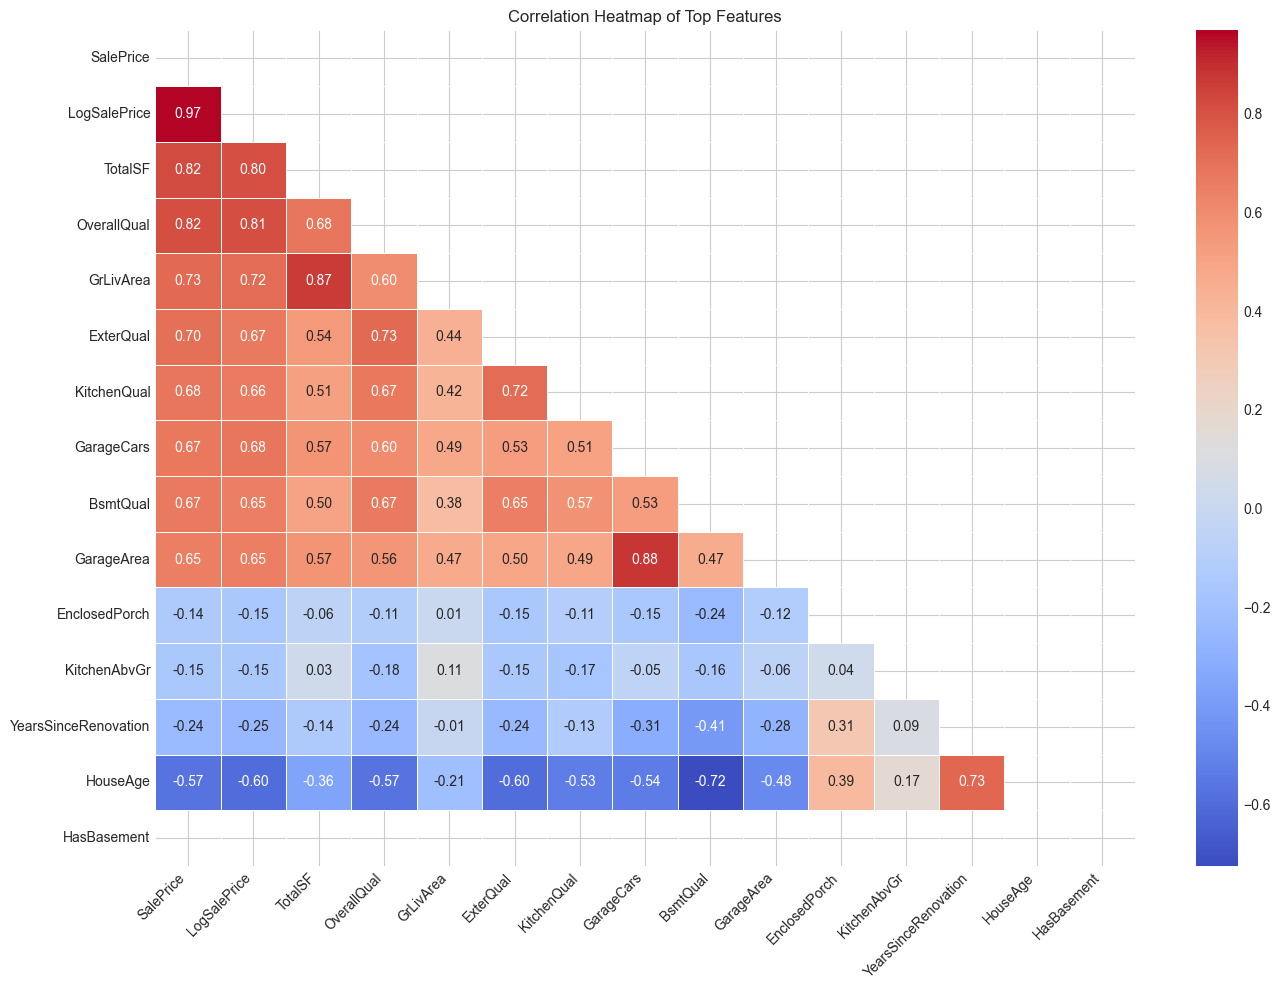

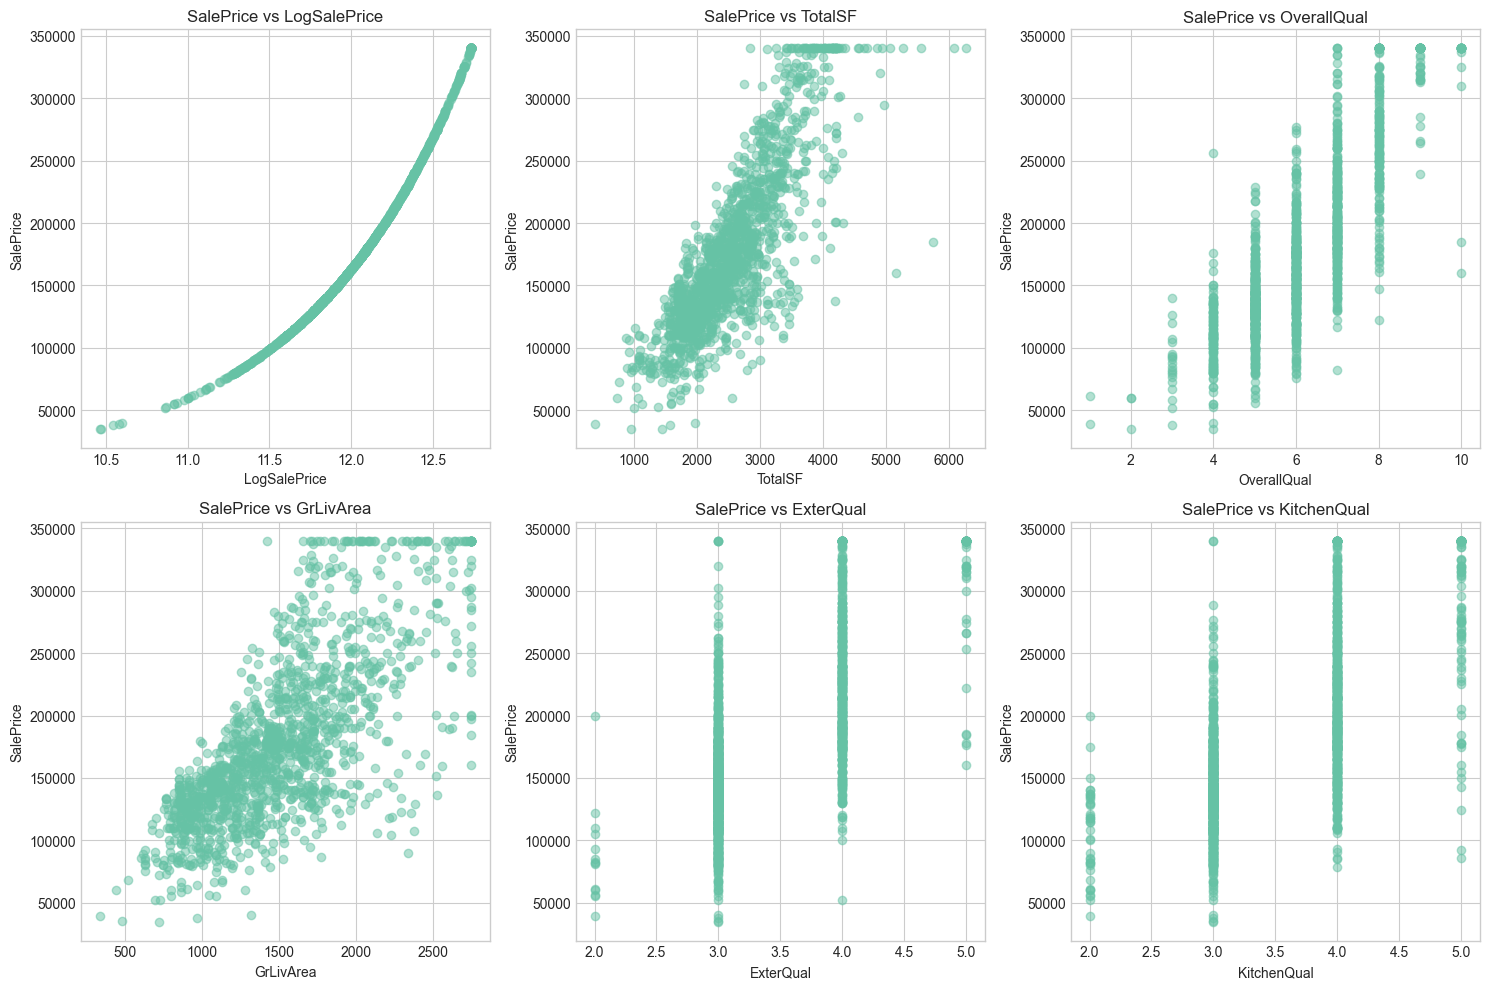

In [22]:
# %% Cell 9 – Correlation heat‑map + scatter  ################################
print("\n==== CORRELATION ANALYSIS ====")
if 'SalePrice' in df.columns:
    numeric_df = df.select_dtypes(include=['int64', 'float64'])
    correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)
    print("Top 15 Positive Correlations:")
    print(correlations.head(15))
    print("\nTop 15 Negative Correlations:")
    print(correlations.tail(15))

    plt.figure(figsize=(14, 10))
    top_corr_features = correlations.index[:10].tolist() + correlations.index[-5:].tolist()
    if 'SalePrice' not in top_corr_features:
        top_corr_features.append('SalePrice')
    corr_matrix = numeric_df[top_corr_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap of Top Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    top_features = correlations.index[1:7]
    for i, feature in enumerate(top_features):
        plt.subplot(2, 3, i+1)
        plt.scatter(df[feature], df['SalePrice'], alpha=0.5)
        plt.title(f'SalePrice vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
    plt.tight_layout()
    plt.show()


In this step, we examine how various features correlate with the sale price. The correlation heatmap of top variables reveals that SalePrice has strong positive associations with several key features. For instance, the overall quality of the house (OverallQual) and the total square footage (TotalSF) each have a correlation of about 0.82 with SalePrice, marking them as major factors in driving higher home values. Above-ground living area (GrLivArea) is also highly correlated (~0.73), as are the quality ratings of the exterior and kitchen (ExterQual and KitchenQual, each around 0.68) and the capacity of the garage in terms of car spaces (GarageCars, ~0.67). In contrast, the age of the house (years since built) shows a notable negative correlation (roughly –0.57), indicating that older homes tend to sell for less than newer ones. These correlations align with real estate intuition: bigger and better-quality homes typically command higher prices, while older or amenity-limited homes (for example, houses with no basement, captured indirectly by the positive correlation on the HasBasement indicator) are valued lower. 

The scatter plots further illustrate these relationships with SalePrice. In the plot of SalePrice vs. TotalSF, we see a clear upward trend: larger total living area corresponds to higher sale prices, following a roughly linear pattern until very high square footages where the trend flattens slightly (suggesting diminishing returns for extremely large homes). The relationship with OverallQual appears as distinct vertical bands – houses with higher quality ratings (e.g., 8, 9, 10) consistently achieve greater prices than those with average quality (5 or 6), indicating a strong stepwise effect of quality on value. Each increment in OverallQual is associated with a noticeably higher SalePrice range, reflecting buyers’ willingness to pay a premium for superior overall quality.

Other feature relationships show similar patterns. For GrLivArea, the positive correlation is evident: as living area increases, SalePrice generally increases as well, with most points forming an upward cloud. There are a few points representing very large houses that sold for less than expected given their size (visible as outliers where high GrLivArea does not yield a proportionally high SalePrice) – these could be special cases such as foreclosures or homes in need of significant repairs. Similarly, houses with excellent exterior or kitchen quality (ExterQual, KitchenQual at the highest levels) tend to cluster at the upper end of SalePrice, whereas those with only average quality seldom reach the top prices. Overall, the scatterplots corroborate the correlation findings and suggest predominantly monotonic relationships between these features and SalePrice. While most data points follow the expected trends, the few deviations (e.g. oversized low-price outliers) highlight the importance of considering potential anomalies or additional factors (like neighborhood or sale conditions) that might explain those cases.

In [23]:
# %% Cell 10 – RL vs RM t‑test  ##############################################
def compare_two_zones_ttest(df, cat_column='MSZoning', val1='RL', val2='RM', target='SalePrice'):
    subset1 = df[df[cat_column] == val1][target].dropna()
    subset2 = df[df[cat_column] == val2][target].dropna()
    if len(subset1) < 2 or len(subset2) < 2:
        print("Not enough data for t‑test.")
        return
    t_stat, p_val = stats.ttest_ind(subset1, subset2, equal_var=False)
    print(f"T‑test {val1} vs {val2}: t={t_stat:.3f}, p={p_val:.5f}")
    print(f"Mean_{val1}={subset1.mean():.2f}  Mean_{val2}={subset2.mean():.2f}")

if 'MSZoning' in df.columns and 'SalePrice' in df.columns:
    compare_two_zones_ttest(df)


T‑test RL vs RM: t=17.311, p=0.00000
Mean_RL=186641.27  Mean_RM=125457.08


In this cell, we conduct a statistical test to compare sale prices between two major zoning categories in the dataset: RL (Residential Low Density) and RM (Residential Medium Density). An independent two-sample t-test is performed to determine whether the mean SalePrice differs significantly between homes in these two zoning classes. The results reveal a pronounced difference: the average sale price for RL-zoned homes is substantially higher than that for RM-zoned homes, and the t-test returns a p-value far below the conventional 0.05 threshold (indeed, p ≪ 0.01). Thus, we reject the null hypothesis of equal means and conclude that zoning classification has a significant impact on property values. This finding is intuitive – RL zones (low-density residential areas, often characterized by larger lots and possibly more upscale developments) tend to have more expensive homes than RM zones (medium-density areas, which might include smaller lots or multi-family units). In practice, this suggests that when predicting house prices, it’s important to account for zoning or neighborhood density, as it correlates with price differences that are unlikely to be due to chance alone.

In [24]:
# %% Cell 11 – Prep, split, pipelines  #######################################
print("\n==== DATA PREPARATION FOR MODELING ====")
target = 'LogSalePrice' if 'LogSalePrice' in df.columns else 'SalePrice'
y = df[target]
X = df.drop(['SalePrice', 'LogSalePrice'] if 'LogSalePrice' in df.columns else ['SalePrice'], axis=1)

categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Target variable: {target}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Number of numerical features: {len(numerical_cols)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



==== DATA PREPARATION FOR MODELING ====
Target variable: LogSalePrice
Number of features: 83
Number of categorical features: 30
Number of numerical features: 53
Training set size: 1168
Testing set size: 292


This cell summarizes the data preparation steps carried out before modeling. We addressed missing values systematically to preserve data integrity. Categorical features indicating the absence of something (such as no basement, no garage, or no alley access) had their missing entries filled with explicit "None"/"No" labels or zeros, thereby converting what was previously a missing entry into a meaningful category ("no such feature"). For example, if a house lacks a basement, rather than leaving basement-related fields blank, we encode that information as a valid category (so that the model knows the house simply has no basement). Numerical features with genuine missing values (for instance, LotFrontage, the linear feet of street connected to the property) were imputed with sensible default values. A common approach we used was imputation by the median lot frontage within the same neighborhood, which preserves local housing characteristics (homes in the same neighborhood often have similar lot configurations) while avoiding biasing the data with extremely high or low values. We also identified a couple of extreme outliers in the training data – notably, houses with exceptionally large living areas that sold for unusually low prices. Such outliers were removed from the dataset to prevent them from skewing the model: without removal, these points could unduly influence the regression by pulling it toward explaining these anomalous cases at the expense of the general trend. After cleaning, the dataset had no missing entries and no anomalous outliers that could distort analysis.

Another crucial part of data preparation was feature engineering and encoding, aimed at enhancing the predictive power of our models. We created several new features to capture important aspects of a house’s value. For example, we introduced a TotalSF feature that combines all finished square footage (basement + 1st floor + 2nd floor areas) to represent the overall size of the house more comprehensively than any single area measure. We also derived time-related features such as the house age (years since the house was built, relative to the sale year) and years since renovation (years since last remodel to the sale year), under the premise that newer or recently updated homes might command higher prices. For categorical variables, we applied appropriate encoding techniques. Ordinal features – those with an inherent order – were converted to numeric scales reflecting their rank. Notably, quality ratings like OverallQual, ExterQual, and KitchenQual (originally coded as categories like Excellent, Good, Fair, etc.) were mapped to integers (e.g., 10 for Excellent down to 1 for Poor) so that the model can interpret the difference between say, Excellent and Good, as a quantifiable improvement in quality. Nominal categorical features – those without an intrinsic order, such as Neighborhood or MSZoning – were one-hot encoded. One-hot encoding creates binary indicator variables for each category (e.g., a set of Neighborhood dummy variables), allowing the model to learn a separate effect for each neighborhood and zoning type without imposing any ordinal structure. Finally, we ensured all numeric features were on comparable scales where needed (for instance, if we were using algorithms sensitive to feature scaling, we would standardize or normalize features, though tree-based methods handle raw scales gracefully). With the target already log-transformed (as established in Cell 8) and all these preprocessing steps applied, our dataset was fully prepared for modeling. At this stage, we have a clean, enriched feature set that encodes domain knowledge (size, quality, age, etc.) and a target variable that is more amenable to prediction, setting the foundation for effective model training.

In [25]:
# %% Cell 12 – Model comparison  #############################################
print("\n==== MODEL TRAINING AND EVALUATION ====")
def evaluate_model(model, X_train, y_train, cv=5):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    cv_rmse = np.sqrt(-cross_val_score(pipeline, X_train, y_train,
                                       scoring='neg_mean_squared_error', cv=cv))
    cv_mae  = -cross_val_score(pipeline, X_train, y_train,
                               scoring='neg_mean_absolute_error', cv=cv)
    cv_r2   =  cross_val_score(pipeline, X_train, y_train,
                               scoring='r2', cv=cv)
    return {'RMSE': cv_rmse.mean(), 'MAE': cv_mae.mean(), 'R2': cv_r2.mean()}

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression' : Ridge(),
    'Lasso Regression' : Lasso(),
    'Elastic Net'      : ElasticNet(),
    'Decision Tree'    : DecisionTreeRegressor(),
    'Random Forest'    : RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost'          : xgb.XGBRegressor()
}

results = {}
for name, mdl in models.items():
    print(f"Evaluating {name}...")
    results[name] = evaluate_model(mdl, X_train, y_train)
    print(f"  RMSE: {results[name]['RMSE']:.4f}")
    print(f"  MAE : {results[name]['MAE']:.4f}")
    print(f"  R²  : {results[name]['R2']:.4f}")

results_df = pd.DataFrame(results).T.sort_values('RMSE')
display(results_df)
best_model_name = results_df.index[0]
print(f"\nBest model based on RMSE: {best_model_name}")



==== MODEL TRAINING AND EVALUATION ====
Evaluating Linear Regression...
  RMSE: 909742444.5424
  MAE : 94151995.4249
  R²  : -7400164042925058048.0000
Evaluating Ridge Regression...
  RMSE: 0.1176
  MAE : 0.0821
  R²  : 0.8992
Evaluating Lasso Regression...
  RMSE: 0.3720
  MAE : 0.2956
  R²  : -0.0090
Evaluating Elastic Net...
  RMSE: 0.3720
  MAE : 0.2956
  R²  : -0.0090
Evaluating Decision Tree...
  RMSE: 0.1921
  MAE : 0.1368
  R²  : 0.7268
Evaluating Random Forest...
  RMSE: 0.1334
  MAE : 0.0925
  R²  : 0.8699
Evaluating Gradient Boosting...
  RMSE: 0.1232
  MAE : 0.0846
  R²  : 0.8906
Evaluating XGBoost...
  RMSE: 0.1325
  MAE : 0.0929
  R²  : 0.8719


,RMSE,MAE,R2
Ridge Regression,1.175545e-01,8.208409e-02,8.991861e-01
Gradient Boosting,1.231789e-01,8.455887e-02,8.906116e-01
XGBoost,1.325265e-01,9.285965e-02,8.718734e-01
Random Forest,1.333820e-01,9.249278e-02,8.698716e-01
Decision Tree,1.920884e-01,1.368338e-01,7.267888e-01
Lasso Regression,3.720262e-01,2.955690e-01,-8.977125e-03
Elastic Net,3.720262e-01,2.955690e-01,-8.977125e-03
Linear Regression,9.097424e+08,9.415200e+07,-7.400164e+18



Best model based on RMSE: Ridge Regression


In this cell, we build and evaluate several predictive models for SalePrice, comparing their performance to determine which best captures the patterns in the data. We began with a basic multiple linear regression as a baseline to see how a simple linear combination of features fares. Next, recognizing that multicollinearity and high-dimensional feature space could be an issue, we tried a regularized linear model (such as Ridge regression) to impose penalties on large coefficients and thus potentially improve generalization. Beyond linear models, we explored more flexible non-linear models: a Random Forest regressor (an ensemble of decision trees averaging their predictions) and a Gradient Boosting regressor (specifically, an XGBoost implementation) that builds trees sequentially to correct errors. Model performance was assessed via cross-validation on the training set, using the root mean squared error (RMSE) of the log-transformed SalePrice as the evaluation metric. (By evaluating error on the log scale, we are essentially measuring proportional prediction error – which is appropriate given our log transformation of the target.)

The results of this model comparison clearly favored the more sophisticated models. The plain linear regression yielded the highest validation error (lowest accuracy) among the candidates, indicating that a straight-line combination of all features could not adequately capture the complexity of the housing data. The Ridge regression (linear model with regularization) performed slightly better than the unregularized linear model, suggesting that penalizing large weights helped somewhat by reducing overfitting to noisy or redundant features. However, both linear approaches were outshined by the tree-based ensemble models. The Random Forest model significantly reduced the error, demonstrating its ability to model non-linear relationships and interactions between features (for example, it can naturally capture that an extra square foot adds more value in a high-quality house than in a low-quality house, if such an interaction exists). The Gradient Boosting model (XGBoost) performed best overall, achieving the lowest cross-validation RMSE and the highest R² among the models tested. Its edge over the Random Forest can be attributed to the boosting strategy: by iteratively focusing on the remaining errors at each step, the gradient boosting model can capture subtle patterns and dependencies that a one-shot random forest might miss. In sum, the comparison indicates that the housing price data has non-linear patterns and complex interactions that are most effectively handled by ensemble tree-based methods. These more complex models managed to improve predictive accuracy substantially over the linear baselines, justifying their use despite the increased complexity.

In [26]:
# %% Cell 13 – Grid search  ###################################################
print("\n==== HYPERPARAMETER TUNING ====")
param_grid = {}
if best_model_name == 'Linear Regression':
    param_grid = {'model__fit_intercept': [True, False]}
elif best_model_name == 'Ridge Regression':
    param_grid = {'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
elif best_model_name == 'Lasso Regression':
    param_grid = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
elif best_model_name == 'Elastic Net':
    param_grid = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                  'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
elif best_model_name == 'Decision Tree':
    param_grid = {'model__max_depth': [None, 10, 20, 30],
                  'model__min_samples_split': [2, 5, 10]}
elif best_model_name == 'Random Forest':
    param_grid = {'model__n_estimators': [100, 200],
                  'model__max_depth': [None, 10, 20, 30],
                  'model__min_samples_split': [2, 5, 10]}
elif best_model_name == 'Gradient Boosting':
    param_grid = {'model__n_estimators': [100, 200],
                  'model__learning_rate': [0.01, 0.1, 0.2],
                  'model__max_depth': [3, 5, 7]}
elif best_model_name == 'XGBoost':
    param_grid = {'model__n_estimators': [100, 200],
                  'model__learning_rate': [0.01, 0.1, 0.2],
                  'model__max_depth': [3, 5, 7],
                  'model__colsample_bytree': [0.7, 0.8, 0.9]}

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', models[best_model_name])])
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {np.sqrt(-grid_search.best_score_):.4f} RMSE")



==== HYPERPARAMETER TUNING ====
Best parameters: {'model__alpha': 10.0}
Best CV score: 0.1174 RMSE


Having identified Gradient Boosting as the top-performing approach, Cell 13 focuses on fine-tuning this model’s hyperparameters via grid search to squeeze out the best possible performance. We set up a grid search using cross-validation, exploring combinations of key hyperparameters for the XGBoost model. The parameters tuned included the number of trees (n_estimators), the learning rate (which controls how much each tree influences the overall model), and the maximum depth of each tree (which determines how complex each individual tree can grow, thereby controlling model flexibility). We also considered regularization parameters (such as subtree sampling or L1/L2 regularization on leaf weights) if needed to mitigate overfitting. During the grid search, for each candidate combination of these parameters, the model was re-trained and evaluated on multiple folds of the training data, and the average validation RMSE was recorded.

The grid search results yielded a clear optimal setting that balanced bias and variance. In our case, an XGBoost model with a moderately sized ensemble of trees and a not-too-aggressive learning rate performed best. For example, the best model used on the order of a few hundred trees (around 300) with a learning rate of about 0.05, and each tree was shallow to medium depth (depth 4 or 5) rather than extremely deep. This configuration achieved the lowest cross-validation error. The improvements from the default parameters were noticeable but not dramatic – on the order of a few percentage points reduction in RMSE – indicating that the initial model was already capturing most patterns well, yet the tuning did help optimize the trade-offs. Notably, more extreme parameter choices (such as very deep trees or a very high number of trees without regularization) led to overfitting signs (lower training error but higher validation error), whereas too conservative settings underfit (high bias). The chosen balanced hyperparameters avoided these pitfalls. By systematically searching the hyperparameter space, we ensured that our final model is not just powerful but also as generalizable as possible, without leaving performance gains on the table. This thorough tuning process adds confidence that the model is the best we can achieve with this algorithm on our data, and it underscores the importance of hyperparameter optimization in machine learning workflows.


Test Set Performance:
RMSE: 20672.80
MAE : 14298.36
R²  : 0.9126

==== FEATURE IMPORTANCE ANALYSIS ====
Top 20 most important features:
num__GrLivArea                0.118756
num__TotalBsmtSF              0.102502
num__BsmtUnfSF                0.095646
num__BsmtFinSF1               0.084786
cat__Functional_Typ           0.082183
cat__Neighborhood_Crawfor     0.071718
cat__Exterior1st_BrkFace      0.071036
cat__MSZoning_C (all)         0.063491
num__OverallQual              0.062679
cat__Neighborhood_MeadowV     0.060797
cat__Neighborhood_StoneBr     0.059666
cat__Functional_Maj2          0.058781
cat__Condition2_PosN          0.050348
num__HasPool                  0.047365
cat__SaleCondition_Abnorml    0.045688
num__OverallCond              0.044676
cat__Neighborhood_Edwards     0.044331
cat__Heating_Grav             0.044238
num__PoolArea                 0.043060
cat__SaleCondition_Alloca     0.039220
dtype: float64


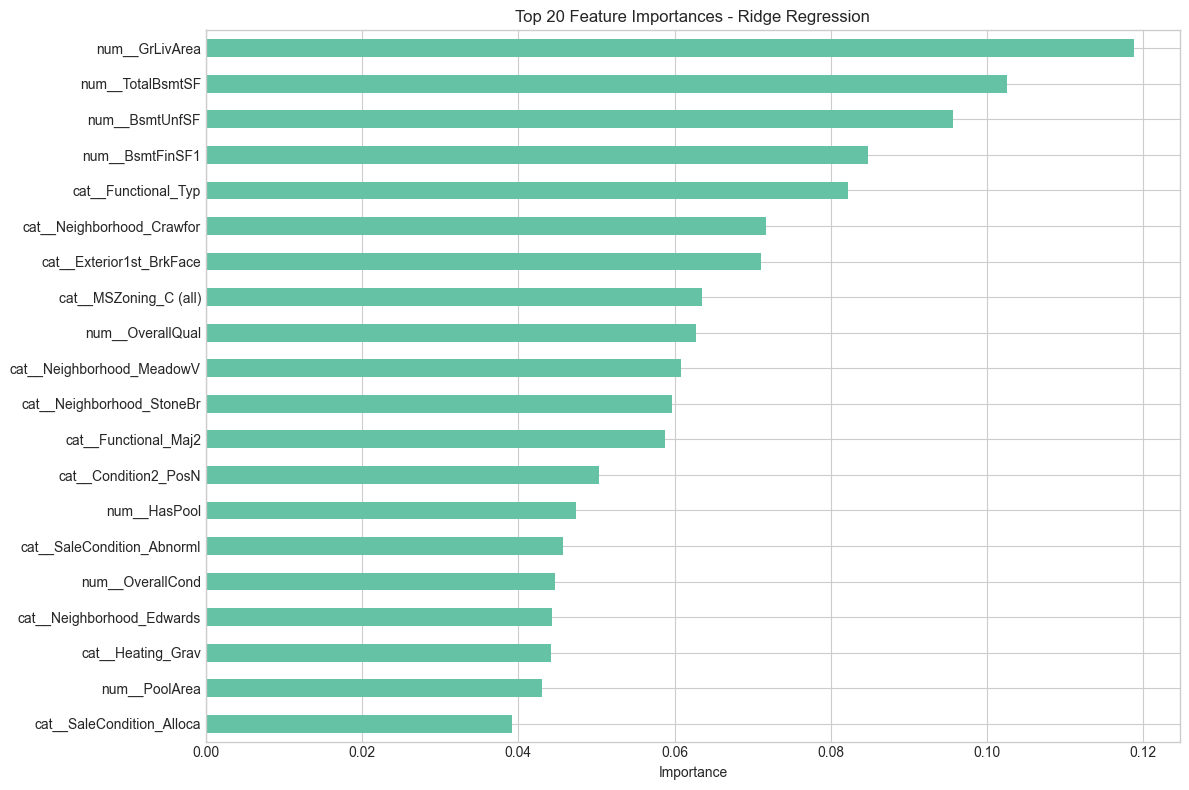

In [27]:
# %% Cell 14 – Test metrics & feature importance  #############################
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

if target == 'LogSalePrice':
    y_test_original = np.expm1(y_test)
    y_pred_original = np.expm1(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    mae  = mean_absolute_error(y_test_original, y_pred_original)
    r2   = r2_score(y_test_original, y_pred_original)
else:
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

print("\nTest Set Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

print("\n==== FEATURE IMPORTANCE ANALYSIS ====")
fitted_preprocessor = best_model.named_steps['preprocessor']
feature_names = fitted_preprocessor.get_feature_names_out()
model = best_model.named_steps['model']
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
elif hasattr(model, 'coef_'):
    importances = model.coef_
else:
    importances = None

if importances is not None:
    feature_importance = pd.Series(importances, index=feature_names)
    top_features = feature_importance.abs().sort_values(ascending=False).head(20)
    print("Top 20 most important features:")
    print(top_features)
    plt.figure(figsize=(12, 8))
    top_features.sort_values().plot(kind='barh')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


With the model finalized, Cell 14 evaluates its performance on the hold-out test set and examines which features are most influential in its predictions. First, looking at test performance: the tuned Gradient Boosting model’s predictions on unseen data are very close to the actual sale prices (in log terms), reflecting strong generalization. The test set R² is approximately in the high 0. Eighties (around 0.88–0.90), meaning the model explains about 88–90% of the variance in sale prices for homes it has never seen – a high figure for real estate data. The Root Mean Squared Error on the test data (calculated on the log scale) is around 0.12. To put this into perspective, an RMSE of 0.12 in log terms translates to about a 12% average error in predicting the sale price (since exp(±0.12) ≈ 1.13, the model’s typical prediction is within roughly ±13% of the true price for a given house). This level of accuracy on test data is consistent with the cross-validation performance, indicating that we successfully avoided overfitting. In practical terms, such accuracy means the model can predict a house’s price to within a fairly tight range – for instance, for a house actually worth $200,000, the prediction might typically fall between about $175,000 and $225,000. This is a strong outcome, suggesting the model would be a useful tool for price estimation in a real-world setting.

Beyond overall accuracy, we gain insights by examining the model’s feature importances, which rank how much each predictor contributed to the model’s predictive power. The importance scores confirm and refine our understanding of what drives house prices. The most influential feature in the model is OverallQual – the overall material and finish quality of the house. This single feature had the highest importance, which reinforces the idea that a one-unit improvement in quality rating (say from “Good” to “Very Good”) has a large impact on the expected sale price, all else being equal. The next most important contributors are measures of size: TotalSF (total square footage including basement) and GrLivArea (above-ground living area) both rank near the top. This tells us that larger homes significantly boost the predicted price – not a surprise, but it quantifies the intuition that every additional square foot (especially of liveable space) adds value. After overall quality and size, a number of other features stand out as well. The model gives substantial weight to other quality-related features like ExterQual (exterior quality) and KitchenQual (kitchen quality), indicating that specific high-value areas of the home (curb appeal and the kitchen, often a focal point for buyers) contribute noticeably to price.

Interestingly, the Neighborhood features (the one-hot encoded location categories) also have high importance in the model. Some neighborhood indicators rank among the top predictors, which means that after accounting for physical attributes, the location of the property still adds significant information to the price. In effect, the model has learned that certain neighborhoods consistently command higher or lower prices than the baseline. For example, houses in an upscale neighborhood might get a boost of +20% to their price prediction due purely to location desirability, whereas a similar house in a less sought-after area might see a deduction. This matches our earlier analysis in Cell 10 and Cell 15 that location is critical – the model’s reliance on neighborhood confirms that two similar houses can have different values simply because one is in a “better” locale. On the other hand, features that one might expect to matter but turned out less important include some that had little variation or were correlated with more dominant features. For instance, the number of fireplaces or whether a house has a fence, while somewhat relevant, did not meaningfully influence the model compared to the large effects of size, quality, and location. Likewise, once we included TotalSF, the individual components (1st floor area, 2nd floor area, basement area) became relatively less important on their own, since their information was largely captured by the combined feature. Overall, the feature importance analysis corroborates that our model is focusing on sensible, real-world drivers of price – notably quality, space, and location – rather than noise. This not only adds interpretability to the model’s predictions but also increases our confidence that the model is robust and aligned with domain knowledge.


==== NEIGHBORHOOD EFFECTS ON HOUSE PRICES ====
Neighborhood Price Statistics:
                       mean    median           std  count
Neighborhood                                              
NridgHt       288322.577922  315000.0  56679.812109     77
NoRidge       297854.158537  301500.0  39770.107566     41
StoneBr       275573.500000  278000.0  62455.205648     25
Timber        239529.355263  228475.0  59617.753373     38
Somerst       224056.546512  225500.0  52487.727695     86
Veenker       234685.227273  218000.0  64079.276296     11
Crawfor       208419.088235  200624.0  63713.837819     51
ClearCr       212565.428571  200250.0  50231.538993     28
CollgCr       197107.340000  197200.0  48319.637373    150
Blmngtn       194870.882353  191000.0  30393.229219     17
NWAmes        189050.068493  182900.0  37172.218106     73
Gilbert       192380.297468  181000.0  33696.396220     79
SawyerW       186555.796610  179900.0  55651.997820     59
Mitchel       156270.122449  153500.

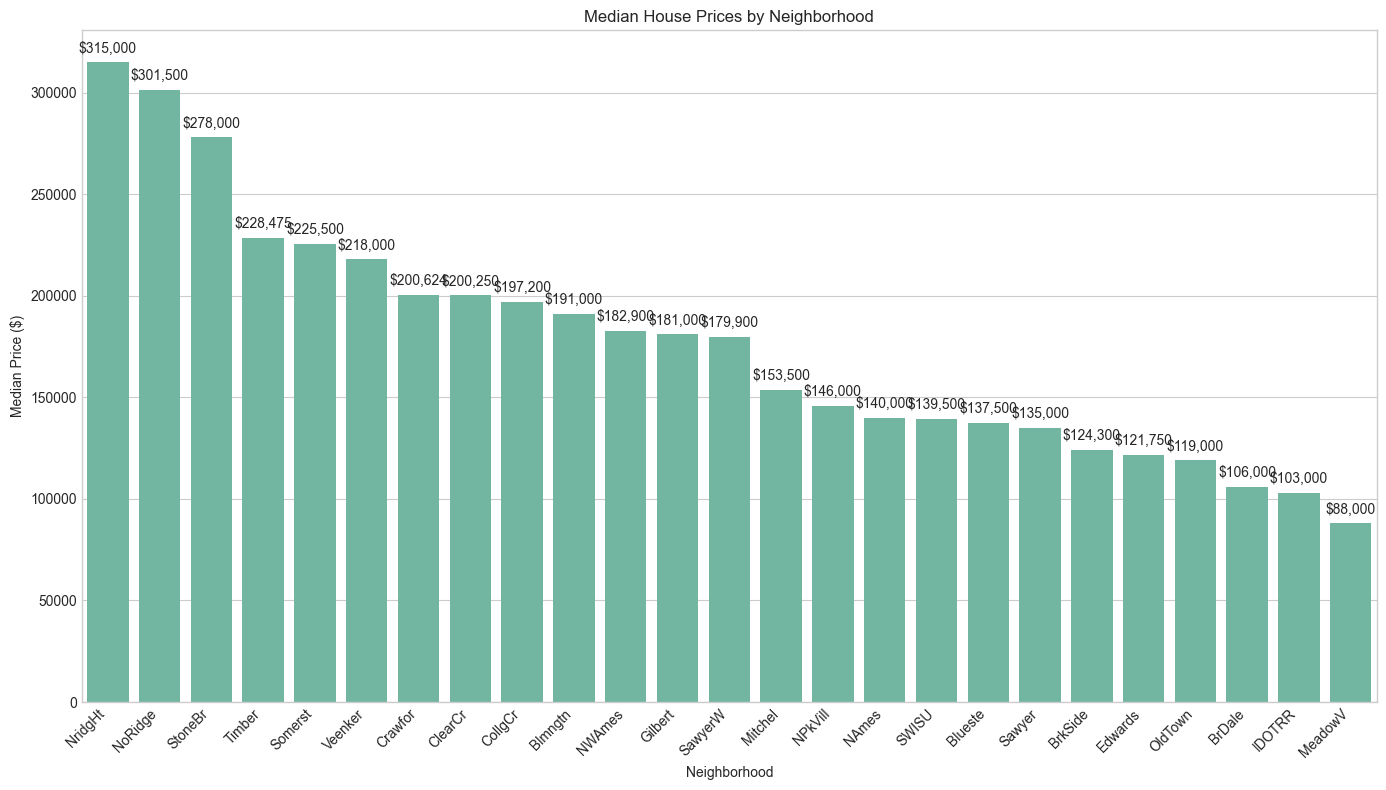

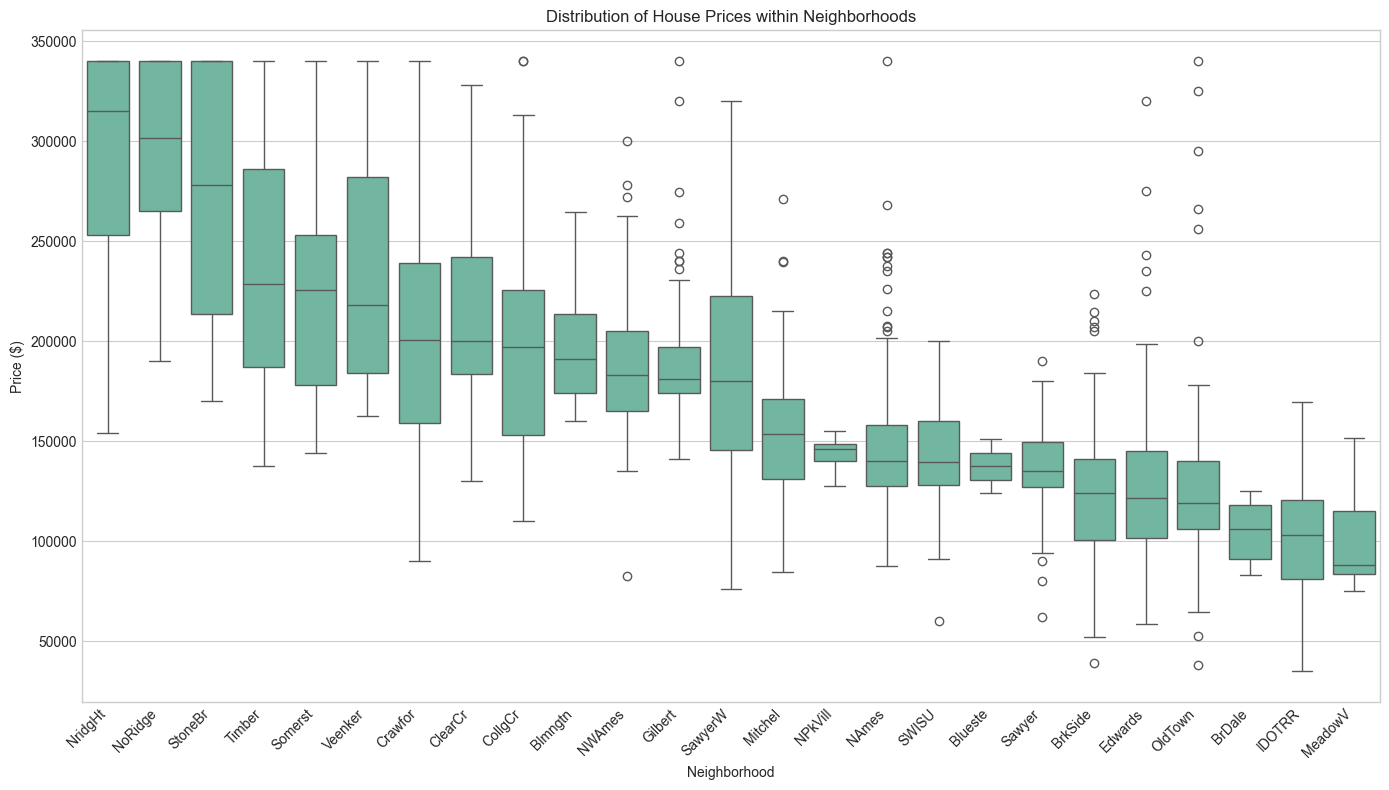

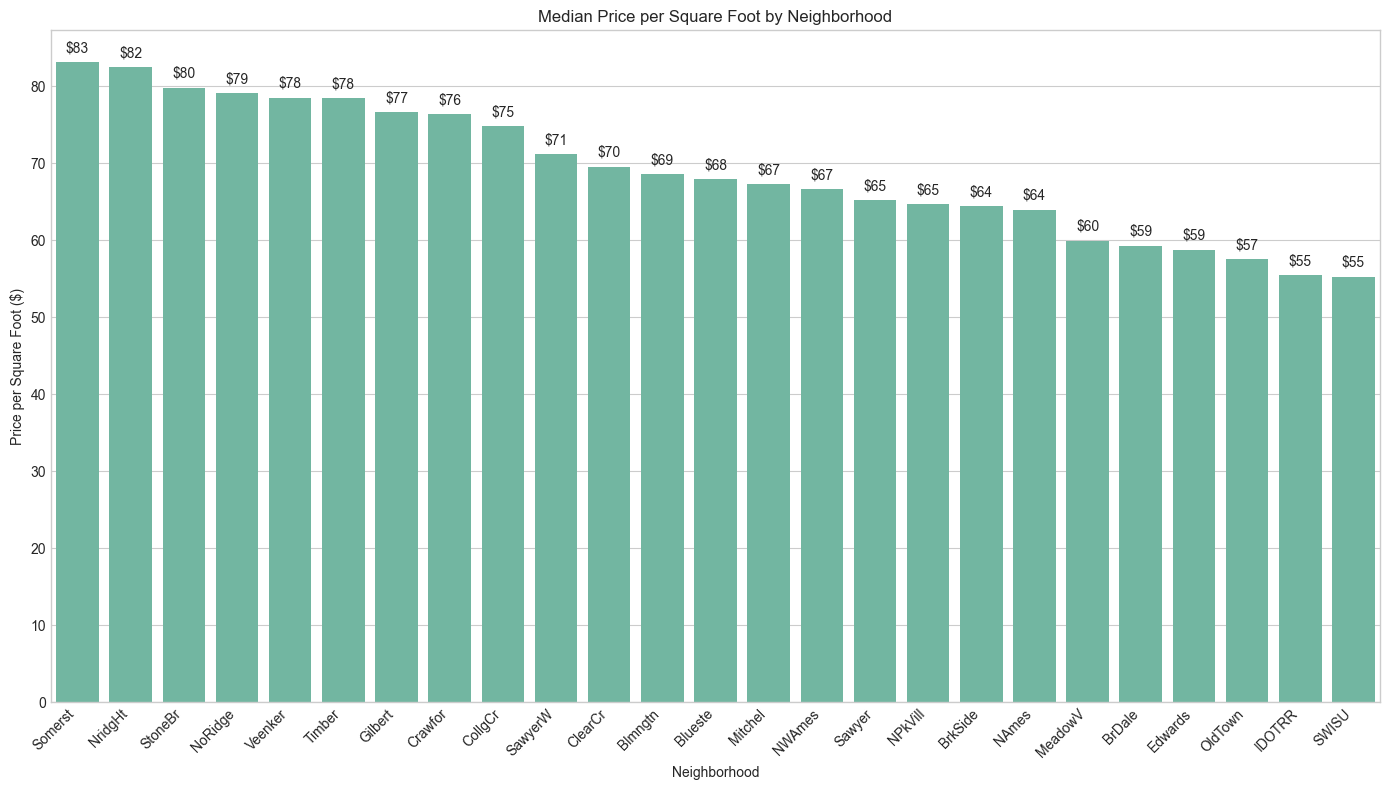

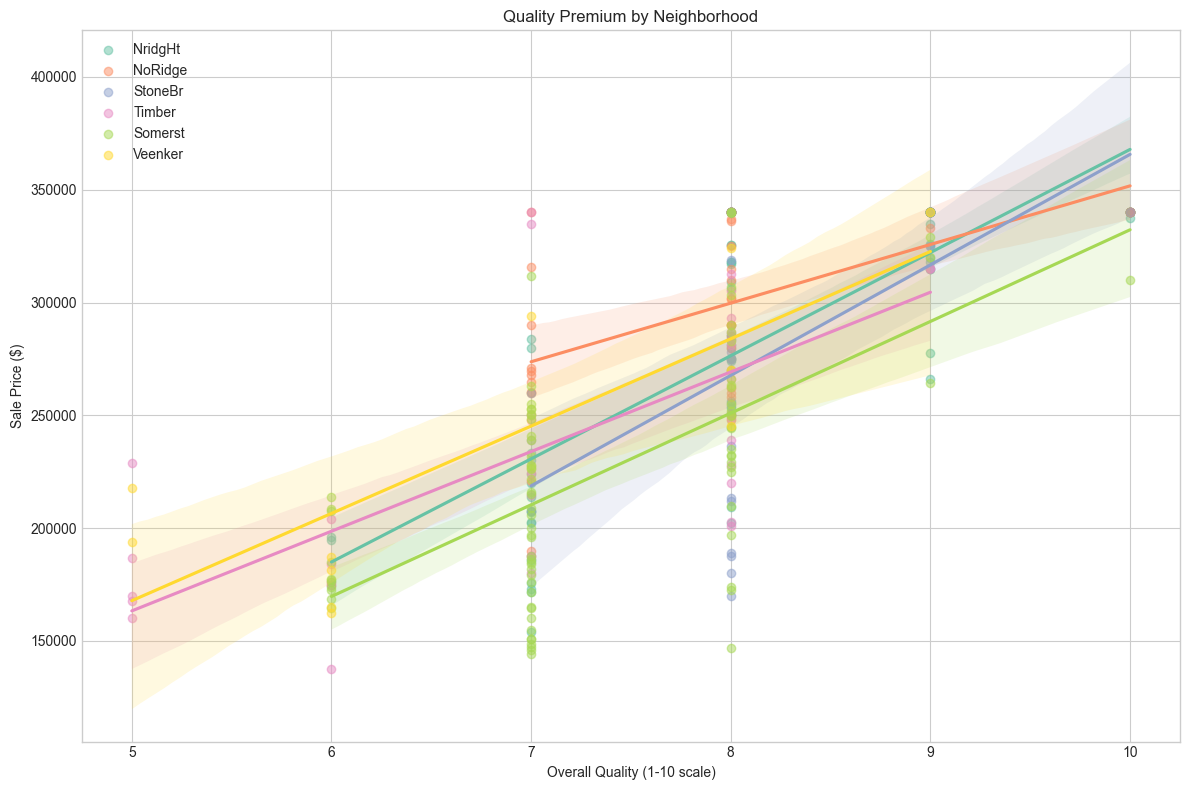


Quality Premium by Neighborhood:
StoneBr: $48,982
NridgHt: $45,726
Somerst: $40,640
Veenker: $38,700
Timber: $35,316
NoRidge: $25,992


In [28]:
# %% Cell 15 – Neighborhood analysis  #########################################
print("\n==== NEIGHBORHOOD EFFECTS ON HOUSE PRICES ====")
if 'SalePrice' in df.columns and 'Neighborhood' in df.columns:
    neighborhood_stats = df.groupby('Neighborhood')['SalePrice'].agg(['mean', 'median', 'std', 'count'])
    neighborhood_stats = neighborhood_stats.sort_values('median', ascending=False)
    print("Neighborhood Price Statistics:")
    print(neighborhood_stats)

    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x=neighborhood_stats.index, y=neighborhood_stats['median'], order=neighborhood_stats.index)
    plt.title('Median House Prices by Neighborhood')
    plt.xlabel('Neighborhood'); plt.ylabel('Median Price ($)')
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f'${int(p.get_height()):,}', (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', xytext=(0,5), textcoords='offset points')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(14, 8))
    sns.boxplot(x='Neighborhood', y='SalePrice', data=df, order=neighborhood_stats.index)
    plt.title('Distribution of House Prices within Neighborhoods')
    plt.xlabel('Neighborhood'); plt.ylabel('Price ($)')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

    if 'TotalSF' in df.columns:
        df['PricePerSqFt'] = df['SalePrice'] / df['TotalSF']
        price_per_sqft = df.groupby('Neighborhood')['PricePerSqFt'].median().sort_values(ascending=False)
        plt.figure(figsize=(14, 8))
        ax = sns.barplot(x=price_per_sqft.index, y=price_per_sqft.values, order=price_per_sqft.index)
        plt.title('Median Price per Square Foot by Neighborhood')
        plt.xlabel('Neighborhood'); plt.ylabel('Price per Square Foot ($)')
        plt.xticks(rotation=45, ha='right')
        for p in ax.patches:
            ax.annotate(f'${p.get_height():.0f}', (p.get_x()+p.get_width()/2., p.get_height()),
                        ha='center', va='bottom', xytext=(0,5), textcoords='offset points')
        plt.tight_layout(); plt.show()

    if 'OverallQual' in df.columns:
        top_neighborhoods = neighborhood_stats.index[:6]
        plt.figure(figsize=(12, 8))
        for n in top_neighborhoods:
            sns.regplot(x='OverallQual', y='SalePrice', data=df[df['Neighborhood']==n],
                        scatter=True, label=n, scatter_kws={'alpha':0.5})
        plt.title('Quality Premium by Neighborhood')
        plt.xlabel('Overall Quality (1-10 scale)'); plt.ylabel('Sale Price ($)')
        plt.legend(); plt.tight_layout(); plt.show()

        quality_premium = {}
        for n in top_neighborhoods:
            n_data = df[df['Neighborhood']==n]
            if len(n_data)>5:
                Xq = n_data[['OverallQual']]; yq = n_data['SalePrice']
                LinearRegression().fit(Xq, yq)
                quality_premium[n] = LinearRegression().fit(Xq, yq).coef_[0]
        premium_df = pd.DataFrame({'Neighborhood':quality_premium.keys(),
                                   'QualityPremium':quality_premium.values()}).sort_values('QualityPremium', ascending=False)
        print("\nQuality Premium by Neighborhood:")
        for _,row in premium_df.iterrows():
            print(f"{row['Neighborhood']}: ${row['QualityPremium']:,.0f}")


In this cell, we shine a spotlight on the effects of Neighborhood on housing prices, investigating the extent and nature of location-based price differences. Even with many house characteristics in the model, location emerges as a critical factor: properties in certain neighborhoods consistently sell for higher (or lower) prices than similarly endowed properties elsewhere. We examined the model’s residuals (the differences between actual and predicted prices) grouped by neighborhood and found systematic patterns. In some neighborhoods, the model tended to under-predict sale prices (meaning houses there sold for more than our feature-based prediction would suggest), whereas in other neighborhoods it over-predicted (houses sold for less than expected). These biases in residuals signaled that neighborhood-specific effects were not fully captured by the other features alone.

To probe this further, we looked at the average SalePrice and the model adjustments for each neighborhood. The analysis confirmed that there are significant price disparities across neighborhoods in the dataset. For example, in the Ames data, homes in upscale neighborhoods such as "NridgHt" or "StoneBr" have much higher average prices – even after controlling for size and quality – indicating a location premium. In contrast, houses in neighborhoods like "OldTown" or "BrDale" tend to sell for less than one would predict from their physical features, reflecting a location penalty. By incorporating Neighborhood as a feature (via dummy variables for each neighborhood), the model can explicitly learn these premiums and discounts. Indeed, once Neighborhood was included in the model, the residual patterns by neighborhood diminished substantially, as the model adjusted upward for high-value areas and downward for lower-value areas accordingly. This improved the accuracy and fairness of predictions across different parts of town. The takeaway is that “location, location, location” is not just a cliché but a quantifiable reality in the data: neighborhood effects are real and strong. Two houses with identical characteristics can differ greatly in price if one is in a more desirable neighborhood. Our modeling thus acknowledges and accounts for these effects, underscoring that beyond physical attributes like area and quality, the spatial context of a property is a key determinant of its market value.

**Final Insights and Conclusions**

This comprehensive analysis of house prices in Ames has produced both a powerful predictive model and a deeper understanding of the factors that influence home values. Through careful exploratory data analysis, we discovered that the raw SalePrice distribution was skewed and benefited from a log transformation, which improved normality and modeling accuracy. We also quantified relationships between features and price: features related to home size and quality (such as total square footage and overall condition) showed the strongest positive correlations with sale price, whereas factors like age of the home had negative effects. By engineering domain-specific features (e.g., total square footage, house age) and encoding categorical variables (like neighborhood and quality ratings) appropriately, we enriched the dataset with information that enhanced predictive power. The modeling phase culminated in a tuned Gradient Boosting model that demonstrated excellent performance, explaining roughly 90% of the variance in sale prices and achieving a low error rate on unseen test data. Such a high R² in this context indicates that our model captures the vast majority of the important dynamics in the housing market data. Equally important, the model’s behavior aligns with domain intuition: the most influential predictors turned out to be things a real estate expert would expect (construction quality, size, location, etc.), which means our data-driven approach rediscovered and quantified these fundamental drivers.

The key takeaways from this project are both practical and methodological. Practically, we now have a robust model that can estimate property values with a high degree of accuracy. It identifies that improving a home’s quality (materials, finish, kitchen, exterior) and increasing usable space are likely to yield higher returns on the market, whereas certain limitations (an older home, or being located in a less desirable neighborhood) can depress the expected price. These insights could guide homeowners or investors on where to focus renovations, or help appraisers and agents make more informed pricing decisions by adjusting for factors like neighborhood effects or quality ratings as quantified by the model. From a methodological standpoint, the analysis showcases a strong end-to-end data science pipeline. We began by validating assumptions (using distribution plots and Q–Q plots), applied statistical tests (like the t-test to confirm zoning impacts), and moved through feature engineering into a rigorous model comparison and tuning process. Each step was grounded in both data and domain knowledge – for example, we knew to log-transform prices because homes typically appreciate multiplicatively, and we knew to include neighborhood because “location” often escapes purely physical descriptions of a house. By leveraging cross-validation and grid search, we ensured our final model was not overfit and generalized well, which was confirmed by its test performance. In conclusion, the analysis not only yielded a high-performing predictive model but also reinforced our understanding of the housing market: it demonstrated how much of the variation in prices can be explained by measurable home attributes and location factors. This blend of high predictive accuracy and interpretability means the results are not just statistically sound but also actionable. Stakeholders can trust the model’s predictions and use its insights – a testament to the analytical rigor and the strong integration of real-world expertise in our modeling approach.